In [1]:

# run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
# load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'


loaded my modules
loaded my own functions


In [2]:
### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [3]:
### Set file names
hisFilePath='../data/raw/'

In [4]:
# define function for calculating spatial mean
def indexMeanMetric(input,iRange,jRange):
    iRange=range(iRange[0],iRange[1]+1)
    jRange=range(jRange[0],jRange[1]+1)
    output = input.isel(eta_rho=iRange, xi_rho=jRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output


In [5]:
iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4

In [6]:
import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sst=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricForecast = indexMeanMetric(sstForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sstForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])


In [7]:
ssh_metricForecast

<xarray.Dataset>
Dimensions:     (ocean_time: 55)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 ... 2011-12-11
Data variables:
    8005        (ocean_time) float64 0.323 0.3064 0.3206 0.3095 ... nan nan nan
    8009        (ocean_time) float64 nan nan nan nan ... 0.2737 0.2707 0.2677

In [8]:
ssh_metricAnalysis

<xarray.Dataset>
Dimensions:     (ocean_time: 55)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 ... 2011-12-11
Data variables:
    8005        (ocean_time) float64 0.3039 0.2774 0.4683 0.5883 ... nan nan nan
    8009        (ocean_time) float64 nan nan nan nan ... 0.2583 0.2509 0.2435

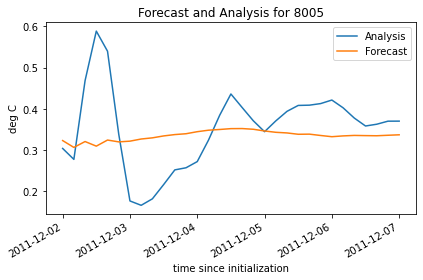

In [9]:
assimPeriod=8005
ssh_metricAnalysis[str(assimPeriod)].plot(label='Analysis')
ssh_metricForecast[str(assimPeriod)].plot(label='Forecast')
plt.legend()
plt.title('Forecast and Analysis for '+str(assimPeriod))
plt.ylabel('deg C')
plt.tight_layout()

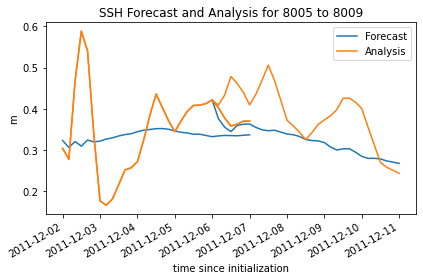

In [10]:
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
plt.legend()
plt.title('SSH Forecast and Analysis for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

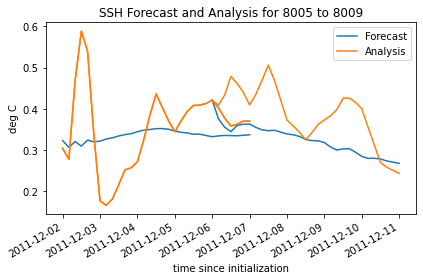

In [11]:
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
plt.legend()
plt.title('SSH Forecast and Analysis for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

In [12]:
sshForecast

<xarray.DataArray 'zeta' (ocean_time: 31, eta_rho: 317, xi_rho: 272)>
array([[[        nan,         nan,         nan, ..., -0.00245399,
         -0.01218401, -0.01218518],
        [        nan,         nan,         nan, ..., -0.00243482,
         -0.01217238, -0.01218634],
        [        nan,         nan,         nan, ...,  0.00272165,
         -0.00875   , -0.00876109],
        ...,
        [        nan,         nan,         nan, ...,  0.48893564,
          0.48678786,  0.48685772],
        [        nan,         nan,         nan, ...,  0.48417249,
          0.48266385,  0.48273098],
        [        nan,         nan,         nan, ...,  0.48420316,
          0.48271806,  0.48272452]],

       [[        nan,         nan,         nan, ..., -0.00902688,
         -0.01162978, -0.01164407],
        [        nan,         nan,         nan, ..., -0.0089105 ,
         -0.0115154 , -0.01165835],
        [        nan,         nan,         nan, ..., -0.01227227,
         -0.01909219, -0.01922834],
...
        [        nan,         nan,         nan, ...,  0.42546142,
          0.42666329,  0.42670244],
        [        nan,         nan,         nan, ...,  0.42173876,
          0.42345093,  0.42354067],
        [        nan,         nan,         nan, ...,  0.42182036,
          0.42353449,  0.42353758]],

       [[        nan,         nan,         nan, ...,  0.02342808,
          0.0178065 ,  0.0178062 ],
        [        nan,         nan,         nan, ...,  0.02343028,
          0.01781094,  0.01780591],
        [        nan,         nan,         nan, ...,  0.02211108,
          0.01638597,  0.01637997],
        ...,
        [        nan,         nan,         nan, ...,  0.42474949,
          0.42598638,  0.42602273],
        [        nan,         nan,         nan, ...,  0.42072067,
          0.42248715,  0.42257396],
        [        nan,         nan,         nan, ...,  0.42079918,
          0.42256829,  0.42257112]]])
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-06 ... 2011-12-11
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  free-surface
    units:      meter
    time:       ocean_time
    grid:       grid
    location:   face
    field:      free-surface, scalar, series

In [146]:
difff = xr.concat((sshForecast,sshAnalysis),'diff').diff(dim='diff').isel(diff=0)
difff.isel(ocean_time=0)# difff.isel(ocean_time=0).plot.pcolormesh('lon_rho','lat_rho')

<xarray.DataArray 'zeta' (eta_rho: 317, xi_rho: 272)>
array([[            nan,             nan,             nan, ...,
        -4.00639721e-06, -3.97254910e-06, -4.41394535e-06],
       [            nan,             nan,             nan, ...,
        -5.23280588e-06, -5.25304760e-06, -5.25299374e-06],
       [            nan,             nan,             nan, ...,
        -5.12899102e-06, -5.18266905e-06, -5.18246304e-06],
       ...,
       [            nan,             nan,             nan, ...,
        -5.50895241e-06, -5.64216301e-06, -5.63950326e-06],
       [            nan,             nan,             nan, ...,
        -5.69131978e-06, -5.78321529e-06, -5.78026058e-06],
       [            nan,             nan,             nan, ...,
        -5.69254468e-06, -5.78454420e-06, -5.78202122e-06]])
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    ocean_time  datetime64[ns] 2011-12-06
Dimensions without coordinates: eta_rho, xi_rho

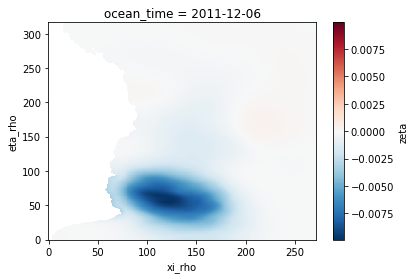

In [148]:
difff.isel(ocean_time=0).plot.pcolormesh()

In [149]:
toPlotTimeStart=0
toPlotTimeEnd=1 #remember exclusive End (it will stop at value before this)


<xarray.DataArray 'zeta' (eta_rho: 317, xi_rho: 272)>
array([[            nan,             nan,             nan, ...,
        -4.00639721e-06, -3.97254910e-06, -4.41394535e-06],
       [            nan,             nan,             nan, ...,
        -5.23280588e-06, -5.25304760e-06, -5.25299374e-06],
       [            nan,             nan,             nan, ...,
        -5.12899102e-06, -5.18266905e-06, -5.18246304e-06],
       ...,
       [            nan,             nan,             nan, ...,
        -5.50895241e-06, -5.64216301e-06, -5.63950326e-06],
       [            nan,             nan,             nan, ...,
        -5.69131978e-06, -5.78321529e-06, -5.78026058e-06],
       [            nan,             nan,             nan, ...,
        -5.69254468e-06, -5.78454420e-06, -5.78202122e-06]])
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
Dimensions without coordinates: eta_rho, xi_rho

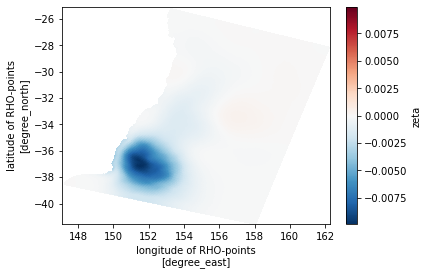

In [150]:
toPlotData.plot.pcolormesh('lon_rho','lat_rho')

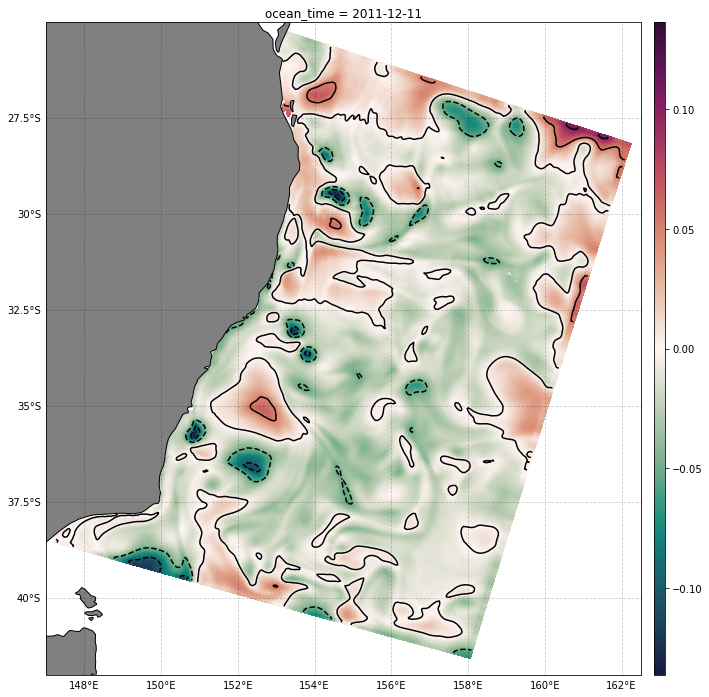

In [102]:
## plot of difference snapshot

toPlotData = xr.concat((sshForecast,sshAnalysis),'diff').diff(dim='diff').isel(diff=0)

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([147, 162.5, -42, -25])

#ax.coastlines(resolution='50m')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.isel(ocean_time=-1).plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
toPlotData.isel(ocean_time=-1).plot.contour('lon_rho','lat_rho', ax=ax, colors='black')

# cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
# fig.colorbar(im, cax=cbar_ax)
plt.colorbar(im, pad=0.02, fraction=0.05, aspect=60)

gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

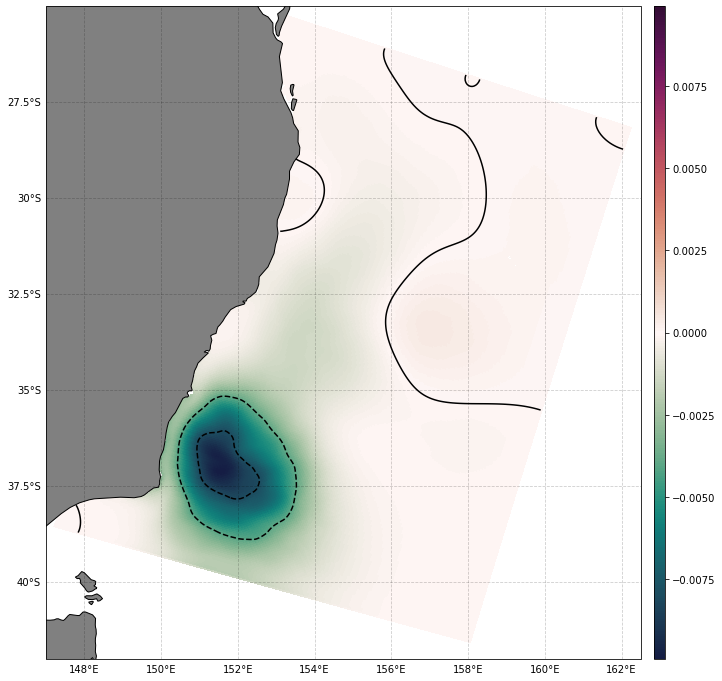

In [152]:
## plot of mean difference over days
toPlotData = xr.concat((sshForecast,sshAnalysis),'diff').diff(dim='diff').isel(diff=0).isel(ocean_time=np.arange(toPlotTimeStart, toPlotTimeEnd)).mean(dim='ocean_time',skipna=True)
toPlotData

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([147, 162.5, -42, -25])

#ax.coastlines(resolution='50m')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')

# cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
# fig.colorbar(im, cax=cbar_ax)
plt.colorbar(im, pad=0.02, fraction=0.05, aspect=60)

gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

plt.title('SSH Analysis - Forecast for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

In [ ]:
toPlotData.is